---

# On the study of Turing instabilities in the $p$ cells reaction-diffusion model with two morphogens  (M2 DEVBIO - HW1)

---

## Some biological context

Nature is known to present patterns, resulting from a perfect balance between regularity and chaos. Probably the most classical example one can give is the strangely regular distribution of petals and pistils in flowers. Based on this observations, mathematicians of the world started to try finding models that could describe best the emergence of these patterns. Some people see a close link with the Fibonacci sequence and the golden ratio $\phi \approx 1.618$, some see a connection to prime numbers' distribution but the existence or not of these links is beyond the scope of this report. We also observe the appearance of patterns in the animal. Whether it is the skin of the zebrafish, the stripes of the zebra, the spots of the giraffe, the back of the ladybug, or a mixture of spots and stripes in the leopard... It would seem that the model introduced in 1952 by Alan Turing, in his paper "The chemical basis of Morphogenesis", covers all these pigmentation processes involved in the generation of all this fauna of shapes.

The goal of this project is, thus, to present and study the 1-dimensional, 2-morphogens, reaction-diffusion equation across $p$-cells arranged on a torus of length $L$, as proposed in 1952.

$$
\begin{equation}
\begin{cases}
\frac{\partial}{\partial t} X (t, s) = D_X \frac{\partial^2}{\partial s^2} X (t, s) + f \bigl( X(t,s), Y(t,s) \bigr), \quad (t, s) \in \Omega
\\ 
\frac{\partial}{\partial t} Y (t, s) = D_Y \frac{\partial^2}{\partial s^2} Y (t, s) + g \bigl( X(t,s), Y(t,s) \bigr), \quad (t, s) \in \Omega
\end{cases}
\end{equation}
$$

where $\Omega = \mathbb{R}^+ \times [0, L]$ and <font color='blue'>$X$</font>, <font color='red'>$Y$</font> denote the quantity of <font color='blue'>activators</font> and <font color='red'>inhibitors</font> respectively. $D_X$ and $D_Y$ are positive real numbers representing diffusion coefficients of the model. Finally, $f$ and $g$ are two functions that defines the reaction between $X$ and $Y$. In our case for Turing's model, $f$ and $g$ are chosen as follows

$$
\begin{align}
f(X, Y) &= 5X - 6Y + 1 \\ g(X, Y) &= 6X - 7Y + 1
\end{align}
$$

## Towards a discretization of the equation using  finite differences

Currently, the model is described using a system of PDE, which we cannot simply simulate. Hence, our way to go is by descretizing the diffusion term using finite differences. We start off by splitting our periodic domain $[0, L]$ into $p$ intervals that are going to define our $p$ cells. for $1 \le r \le p$, we let $X_r$, $Y_r$ denote the quantity of activator and inhibitor in cell $r$.

**Remark:** Since our domain has periodic boundary condition, we have that $X_{p+1} = X_1$, and $Y_{p+1} = Y_1$.

It is only left to discretize our diffusion term using two, third-order Taylor expansion around $s$ (one above $s$, one below). This results in the common expression of the 1D discrete Laplacian operator (modulo some term in $\mathcal o (h^4)$)

$$\frac{\partial^2 X_r}{\partial s^2} = \frac{X_{r-1} - 2X_r - X_{r+1}}{h^2}$$

Assuming that $h = 1$ for now, we thus land on the final system of $2p$ equations at the heart of our study.


$$
\begin{equation}
\begin{cases}
\frac{\partial}{\partial t} X_r = D_X (X_{r-1} - 2X_r + X_{r+1}) + 1 + 5X_r - 6Y_r, \quad 1 \le r \le p
\\ 
\frac{\partial}{\partial t} Y_r = D_Y (Y_{r-1} - 2Y_r + Y_{r+1}) + 1 + 6X_r - 7Y_r, \quad 1 \le r \le p
\end{cases}
\end{equation}
$$


## Parameters and building stones of the program

The code presented in this report has a very linear structure and will be assembled step by step through each chunk of code. The first natural step is to import packages that will be mandatory for the well-being of our program

In [2]:
import numpy as np # obviously.
from numpy import exp, cos, sin, pi # some shortcuts

import matplotlib.pyplot as plt # plotting and visuals
from matplotlib.lines import Line2D # custom legend for curves
from scipy.integrate import odeint # numerical integration for ODE simulation
plt.style.use("ggplot") # visual style that I personaly like :)

# restore classic colormap
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

# adjust figures' size
plt.rcParams['figure.figsize'] = (16, 9)

Let us proceed by introducing a few parameters that will be temporarly fixed during the simulations

In [3]:
p = 5 # number of cells
D_X = 0.5 # diffusion coefficient of chemical X
D_Y = 0.5 # diffusion coefficient of chemical Y

Noticing that our system is linear (affine, precisely), we swap the rows of the system so that the $(X_r)_r$ and $(Y_r)_r$ terms are grouped and rewrite it using matrices under the form $Z' = M_{2p}Z + v$ (using the courses' notation), *i.e.:*

$$
\begin{equation}
\underbrace{
\frac{\text{d}}{\text{d} t} \begin{bmatrix}X_1 \\ \vdots \\ X_p \\ Y_1 \\ \vdots \\ Y_p \end{bmatrix}}_{Z'} = 
\underbrace{
\left[\begin{array}{c|c}
\begin{matrix} & \\ 5 \cdot \text{I}_p - D_X A_p^{\text{diff}} \, \\ & \end{matrix} & \begin{matrix} & \\ -6 \cdot \text{I}_p \\ & \end{matrix} \\ \hline
\begin{matrix} & \\ \quad & 6 \cdot \text{I}_p & \qquad \\ & \end{matrix} & \begin{matrix} & \\ -7 \cdot \text{I}_p - D_Y A_p^{\text{diff}} \\ & \end{matrix}
\end{array}
\right]}_{M_{2p}}
\underbrace{\begin{bmatrix}X_1 \\ \vdots \\ X_p \\ Y_1 \\ \vdots \\ Y_p \end{bmatrix}}_{Z}
+
\underbrace{
\begin{bmatrix}
1 \\ \vdots \\ \\ \\ \vdots \\ 1
\end{bmatrix}}_{v}
\end{equation}
$$


where $\text{I}_p \in \mathcal{M}_p(\mathbb R)$, is the identity matrix and $A_p^{\text{diff}} \in \mathcal{M}_p(\mathbb R)$ corresponds to the matrix associated to the usual discrete Laplacian. Let's incorporate this new information to the code.

In [4]:
# a little bit overkill, but still useful as a short for the identity matrix
def I(p):
    return np.eye(p)

# define the discrete Laplacian
def diffusion_matrix(n):
    # deal with the special case of p=2
    if (n == 2):
        return np.array([[1, -1],[-1, 1]], dtype='float')
    # not the best way to implement it, but will do the job here
    else:
        A = np.zeros((n,n))
        for i in range(n):
            A[i, i] = 2
            for j in range(i, n):
                if j == (i+1):
                    A[i, j] = -1
                    A[j, i] = -1
        # periodic boundary condition
        A[0, -1] = -1
        A[-1, 0] = -1
        return A

When writing scripts whose purpose is to generate simulations at a general level, it is always a good habit to proofcheck what's being written regularly. Let us then call the ```I``` and ```diffusion_matrix``` functions to make sure of their well implementation to the code. Let us do a quick check with $p=3$ , we expect the following output

$$
\texttt{I(p)} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}, \quad
\texttt{diffusion}\_\texttt{matrix(p)} = \begin{bmatrix} 2 & -1 & 0 \\ -1 & 2 & -1 \\ 0 & -1 & 2 \end{bmatrix}
$$

In [5]:
print(I(3), "\n\n", diffusion_matrix(3))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

 [[ 2. -1. -1.]
 [-1.  2. -1.]
 [-1. -1.  2.]]


## A first simulation with Turing's toy model

So far so good, we now implement the $M_{2p}$ matrix as well as the function $F : Z \longmapsto MZ + v$ such that $Z' = F(Z)$.

In [6]:
# define each block of the M matrix
Mxx = 5 * I(p) - D_X * diffusion_matrix(p) # upper-left block
Myy = -7 * I(p) - D_Y * diffusion_matrix(p) # bottom-right block
Mxy = -6 * I(p) # upper-right block
Myx = 6 * I(p) # bottom-left block

# the full M matrix
M = np.block([[Mxx, Mxy], [Myx, Myy]]) 

# the v vector made of 1s
v= np.ones(2*p)
    
# define the function F
F = lambda Z, t, M, v: M @ Z + v

Once again, another check is required here. Let us ask the program to display $M_{2p}$ and $v$ altogether.

In [7]:
print(M, "\n\n", v)

[[ 4.   0.5  0.   0.   0.5 -6.  -0.  -0.  -0.  -0. ]
 [ 0.5  4.   0.5  0.   0.  -0.  -6.  -0.  -0.  -0. ]
 [ 0.   0.5  4.   0.5  0.  -0.  -0.  -6.  -0.  -0. ]
 [ 0.   0.   0.5  4.   0.5 -0.  -0.  -0.  -6.  -0. ]
 [ 0.5  0.   0.   0.5  4.  -0.  -0.  -0.  -0.  -6. ]
 [ 6.   0.   0.   0.   0.  -8.   0.5 -0.  -0.   0.5]
 [ 0.   6.   0.   0.   0.   0.5 -8.   0.5 -0.  -0. ]
 [ 0.   0.   6.   0.   0.  -0.   0.5 -8.   0.5 -0. ]
 [ 0.   0.   0.   6.   0.  -0.  -0.   0.5 -8.   0.5]
 [ 0.   0.   0.   0.   6.   0.5 -0.  -0.   0.5 -8. ]] 

 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Wonderful! Everything is now ready for us to fire some simulations using the ```odeint``` command. This is nothing but the usual routine ; to spice things up, we choose a random starting point $Z_0 \in \mathcal{M}_{2p, 1}(\mathbb R)$ with each entry between $0$ and $2$. Next, we specify the time domain on which we seek to integrate our equation on. In the parameters chunk, we set $T = 8$ (chosen empirically to ensure long enough trajectories) as well a a discretization step $1/N$, $N = 1000$.

In [8]:
Z0 = 2*np.random.rand(2*p) # choose a random starting point in [0, 2]^2p

T = 8 # final time for system evolution
N = 1000 # how many pieces we cut [0, T] in (time step = 1/N)
time = np.linspace(0, T, N) # split [0, T] in N bits (discretize time)

y = odeint(F, Z0, time, args=(M,v, )) # numerically solve the ODE system

The number of variables being too large to construct a phase portrait, we restrict ourselves to plot a few trajectories of each quantity with respect to time for a changing value of $D_Y$ :

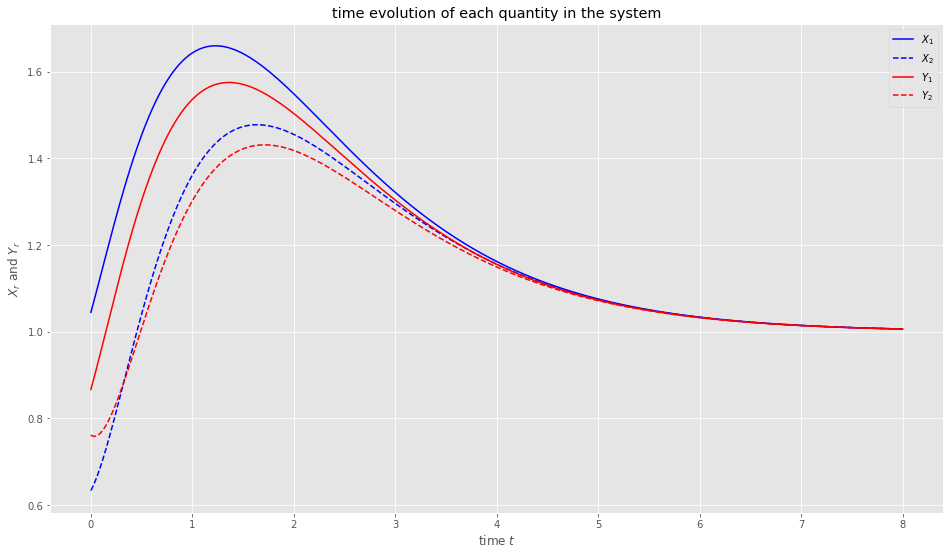

In [9]:
# plot X_1, X_2, Y_1, Y_2 w.r.t. time
plt.plot(time, y[:, 0], 'blue', label=r"$X_1$")
plt.plot(time, y[:, 1], 'blue', ls="--", label=r"$X_2$")
plt.plot(time, y[:, p + 0], 'red', label=r"$Y_1$")
plt.plot(time, y[:, p + 1], 'red', ls="--", label=r"$Y_2$")

# display parameters
plt.title("time evolution of each quantity in the system")
plt.legend()
plt.xlabel(r"time $t$")
plt.ylabel(r"$X_r$ and $Y_r$");

## Towards a more rigid structure of the code by refactoring previous chunks into a single function.

Since we will later want to test our code with different values of ($D_X, D_Y$) to witness Turing instabilities, let us build a function that draws a few trajectories given a set $(B, D_X, D_Y, p)$ (having in mind that we try to reproduce the six graphs from the slides). Therefore, the following function is nothing but a summary of what we said 

In [10]:
def build_trajectories(B, D_X, D_Y, p):
    # retrieve coefficients of the B matrix
    b_xx = B[0, 0]
    b_xy = B[0, 1]
    b_yx = B[1, 0]
    b_yy = B[1, 1]

    # define each block of the M matrix (general case)
    Mxx = b_xx * I(p) - D_X * diffusion_matrix(p) # upper-left block
    Myy = b_yy * I(p) - D_Y * diffusion_matrix(p) # bottom-right block
    Mxy = b_xy * I(p) # upper-right block
    Myx = b_yx * I(p) # bottom-left block

    # the full M matrix
    M = np.block([[Mxx, Mxy], [Myx, Myy]]) 

    # vector of 1s
    v= np.ones(2*p)

    # function F
    F = lambda Z, t, M, v: M @ Z + v
    
    T = 20
    
    Z0 = 2*np.random.rand(2*p) # choose a random starting point in [0, 2]^2p
    time = np.linspace(0, T, N) # split [0, T] in N bits (discretize time)
    y = odeint(F, Z0, time, args=(M,v, )) # numerically solve the ODE system
    
    # return the computed tailor-made solution + metadata
    return (y, p, D_X, D_Y, B)

Notice this is nothing less than an adapted version of the last chunks of code. We can now fix $D_X := 0.5$ and test our function for different values of $D_Y$ in $[0.7, 1.2]$ to mimic the slides.

In [11]:
p = 10 # amount of cells

D_X = 0.5 # diffusion of X
D_Ys = np.array([0.7 + 0.1*i for i in range(6)], dtype='float') # diffusion of Y

B = np.array([[5, -6],[6, -7]], dtype='float') # turing matrix B

## compute a solution FOR EACH D_Y
sols = []
for D_Y in D_Ys:
    sol = build_trajectories(B, D_X, D_Y, p)
    sols.append(sol)

Let us now plot each solution on a separate plot for the sake of readability (to this end, we will also plot only $X_1$, $X_2$, $Y_1$, $Y_2$ otherwise the plots are not readable).

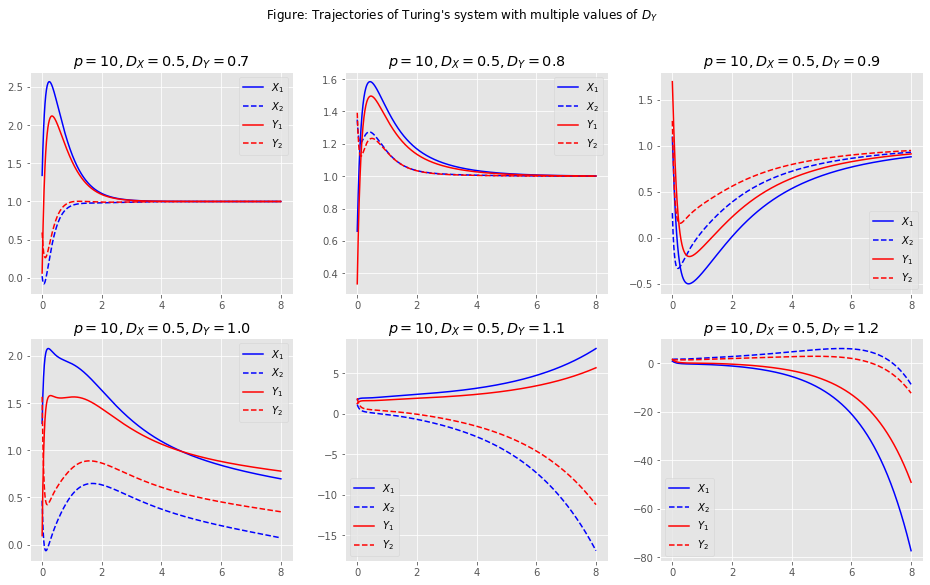

In [12]:
fig, axs = plt.subplots(2, 3)

for i in range(2):
    for j in range(3):
        ax = axs[i, j] # fetch appropriate axis
        sol, p, dx, dy, b = sols[2*i + j + i] # fetch appropriate sol
        
        
        # plot X_1, X_2, Y_1, Y_2
        ax.plot(time, sol[:, 0], 'blue', label=r"$X_1$")
        ax.plot(time, sol[:, 1], 'blue', ls="--", label=r"$X_2$")
        ax.plot(time, sol[:, p + 0], 'red', label=r"$Y_1$")
        ax.plot(time, sol[:, p + 1], 'red', ls="--", label=r"$Y_2$")
        
        ax.legend()
        ax.set_title(rf"$p = {p}, D_X = {np.round(dx, 3)}, D_Y = {np.round(dy, 3)}$")
    
plt.suptitle(r"Figure: Trajectories of Turing's system with multiple values of $D_Y$");

Here, we observe this is exactly what we expected... Fantastic!

## Finding diffusion coefficients inducing instabilities 

As illustrated by the previous figure, there are some values of $(D_X, D_Y)$ for which, the system seems to behave completely differently. This is due to a change in the nature of the equilibrium point $Z^* := (1, ..., 1)^T$. By definition of the system, it happens we have stability when the real part of each eigenvalue of $M_{2p}$ is negative. Using algebraic surgery (an argument on the eigenvalues and eigenvectors of the discrete Laplacian and matrix conjugation enabling us to transform our system $Z' = M_{2p}Z + v$ to $Z' = \bar M Z$), we show the following result

$$Z^* \text{ is stable }
\quad \iff \quad
\text{sp} \underbrace{\begin{bmatrix}b_xx - D_X \mu_k & b_xy \\ b_yx & b_yy - D_y \mu_k \end{bmatrix}}_{\bar M_2(\mu_k)} \subset \mathbb R_{<0}, \quad k = 1, ..., p$$

Where $\mu_k := 2 \left( 1 - \cos\left( \frac{2k \pi}{p}\right)\right)$ and $\bar M = \text{diag}(\bar M_2(\mu_1), \dots, \bar M_2(\mu_p))$. Us being the bad guys of this story, we seek for values of $D_X, D_Y$ inducing the instability of $Z^*$. By our criterion, since $\text{Tr} \left(\bar M_2(\mu_k) \right) < 0$, it suffices to find $1 \le k \le p$ so that the eigenvalues of $\bar M_2(\mu_k)$ are of opposite sign, *i.e.* $\det \bar M_2(\mu_k) < 0$. Choice is ours, let us pick a value of $k$ and find the appropriate $D_X, D_Y$ as wanted.

In [16]:
k = 5 # pick k in {1, ..., p} as desired
mu_k = 2 * (1 - np.cos(2*k*pi / p)) # mu value of the k-th bloc in \bar{M}

lam = 0.5 # lambda as proposed
lam2 = lam * lam

# need those guys
b_xx = B[0, 0]
b_xy = B[0, 1]
b_yx = B[1, 0]
b_yy = B[1, 1]

newD_X = (b_xx + + b_yy * lam2) / (2 * mu_k)
newD_Y = D_X / lam2

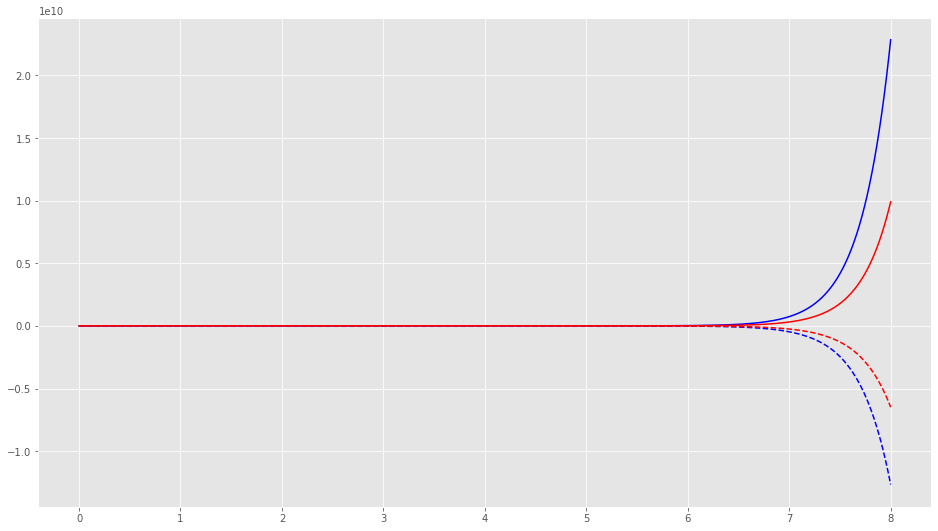

In [26]:
## TEST
sol, p, dx, dy, b = build_trajectories(B, newD_X, newD_Y, p)

plt.plot(time, sol[:, 0], 'blue', label=r"$X_1$")
plt.plot(time, sol[:, p-1], 'blue', ls="--", label=r"$X_2$")
plt.plot(time, sol[:, p + 0], 'red', label=r"$Y_1$")
plt.plot(time, sol[:, p + p-1], 'red', ls="--", label=r"$Y_2$");